# Reconstruct Video

In [4]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os

In [5]:
from sklearn.cluster import KMeans

In [6]:
# Paths and settings
data_path = 'data/raw_full_match_aston_villa_v_chelsea.json'
video_path = 'data/processed_full_match_aston_villa_v_chelsea.webm'
output_file = 'data/output_video2.mp4'
fps = 30

# Load JSON data
with open(data_path, 'r') as f:
    data = json.load(f)

In [16]:
unique_ids={}
for frame in data:
    for player_id in data[frame]:
        #player_id=int(player_id)
        x= data[frame][player_id]['map_x']
        y=data[frame][player_id]['map_y']
        if player_id in unique_ids:
            unique_ids[player_id].append([x,y])
        else:
             unique_ids[player_id]=[[x,y]]

# clustering

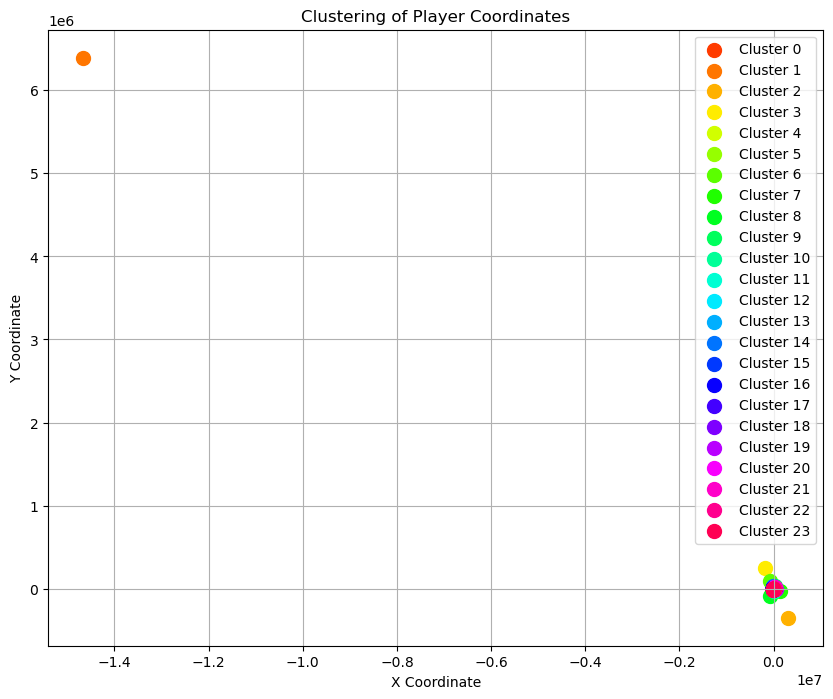

Old IDs to New Clusters Mapping:
1 -> Cluster {0}
2 -> Cluster {0}
3 -> Cluster {0, 18}
4 -> Cluster {0, 18, 12}
6 -> Cluster {0, 18, 12}
8 -> Cluster {0, 18}
7 -> Cluster {0}
9 -> Cluster {0, 18, 12}
10 -> Cluster {0, 17, 18, 12}
12 -> Cluster {0, 17, 12}
13 -> Cluster {0, 18, 12}
14 -> Cluster {0, 17, 18, 12}
15 -> Cluster {12}
11 -> Cluster {12}
5 -> Cluster {18, 12}
18 -> Cluster {12}
16 -> Cluster {0, 18, 12}
17 -> Cluster {17, 12}
19 -> Cluster {12}
20 -> Cluster {0, 17, 12}
21 -> Cluster {12}
22 -> Cluster {12}
23 -> Cluster {12}
24 -> Cluster {0, 18, 12}
25 -> Cluster {0, 18, 12}
26 -> Cluster {0, 18, 12}
27 -> Cluster {12}
28 -> Cluster {12}
29 -> Cluster {17}
30 -> Cluster {12}
31 -> Cluster {17}
32 -> Cluster {12}
33 -> Cluster {12}
34 -> Cluster {12}
36 -> Cluster {12}
35 -> Cluster {12}
37 -> Cluster {12}
38 -> Cluster {12}
39 -> Cluster {12}
40 -> Cluster {12}
41 -> Cluster {12}
42 -> Cluster {12}
47 -> Cluster {12}
48 -> Cluster {12}
49 -> Cluster {12}
50 -> Cluster {12}

In [22]:
# Flatten the coordinates into a 2D list (each entry is a coordinate pair)
all_coordinates = [coord for coords in unique_ids.values() for coord in coords]

# Convert to numpy array for KMeans
all_coordinates = np.array(all_coordinates)

# Perform KMeans clustering
n_clusters = 24 # Number of clusters you want (new IDs)
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(all_coordinates)

# Map original IDs to their new cluster assignments
id_to_new_clusters = {}
clustered_coordinates = {i: [] for i in range(n_clusters)}

# Assign the original IDs to their new clusters
index = 0
for player_id, coords in unique_ids.items():
    cluster_ids = [clusters[index + i] for i in range(len(coords))]
    id_to_new_clusters[player_id] = cluster_ids  # Map old IDs to their clusters
    for i in range(len(coords)):
        cluster_id = clusters[index + i]
        clustered_coordinates[cluster_id].append(all_coordinates[index + i])
    index += len(coords)

# Plot the clusters
palette = sns.color_palette("hsv", n_clusters)

plt.figure(figsize=(10, 8))
for cluster_id, points in clustered_coordinates.items():
    points = np.array(points)
    if len(points) > 0:
        plt.scatter(points[:, 0], points[:, 1], c=[palette[cluster_id]], label=f"Cluster {cluster_id}", s=100)


plt.title("Clustering of Player Coordinates")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.grid()
plt.show()

# Step 4: Output re-assigned IDs and coordinates
print("Old IDs to New Clusters Mapping:")
for old_id, cluster_id in id_to_new_clusters.items():
    print(f"{old_id} -> Cluster {set(cluster_id)}")

print("\nClustered Coordinates:")
for cluster_id, points in clustered_coordinates.items():
    print(f"Cluster {cluster_id}: {points}")

# provided file 

In [3]:
# Open video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Prepare output video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = None  # Initialize later with frame dimensions

# Process frames based on frame numbers in JSON data
frame_counter = 0
while True:
    ret, frame = cap.read()

    # Stop if no more frames or if we've reached the first 1000 frames
    if not ret or frame_counter > 1000:
        break

    # Resize frame to standard dimensions
    frame = cv2.resize(frame, (1920, 1080)).astype('uint8')

    # Process if frame number exists in JSON data
    frame_str = str(frame_counter)  # Convert frame counter to string for JSON lookup
    if frame_str in data:
        for player in data[frame_str]:
            # Extract bbox coordinates from JSON data
            x1, y1, x2, y2 = [data[frame_str][player][x] for x in ['object_x1', 'object_y1', 'object_x2', 'object_y2']]

            # Draw bbox and player ID on frame
            frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            frame = cv2.putText(frame, f'Player {player}', (x1, y1 - 3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    # Initialize output writer once frame size is known
    if out is None:
        frame_size = (frame.shape[1], frame.shape[0])
        out = cv2.VideoWriter(output_file, fourcc, fps, frame_size)
    

    # Write frame to output video
    out.write(frame)

    # Increment frame counter
    frame_counter += 1

# Release resources
cap.release()
if out is not None:
    out.release()



# Heatmap for each player

In [6]:
unique_ids={}
for frame in data:
    for player_id in data[frame]:
        #player_id=int(player_id)
        if player_id in unique_ids:
            continue
        else:
             unique_ids[player_id]=[[],[]]
             
       
unique_ids

{'1': [[], []],
 '2': [[], []],
 '3': [[], []],
 '4': [[], []],
 '6': [[], []],
 '8': [[], []],
 '7': [[], []],
 '9': [[], []],
 '10': [[], []],
 '12': [[], []],
 '13': [[], []],
 '14': [[], []],
 '15': [[], []],
 '11': [[], []],
 '5': [[], []],
 '18': [[], []],
 '16': [[], []],
 '17': [[], []],
 '19': [[], []],
 '20': [[], []],
 '21': [[], []],
 '22': [[], []],
 '23': [[], []],
 '24': [[], []],
 '25': [[], []],
 '26': [[], []],
 '27': [[], []],
 '28': [[], []],
 '29': [[], []],
 '30': [[], []],
 '31': [[], []],
 '32': [[], []],
 '33': [[], []],
 '34': [[], []],
 '36': [[], []],
 '35': [[], []],
 '37': [[], []],
 '38': [[], []],
 '39': [[], []],
 '40': [[], []],
 '41': [[], []],
 '42': [[], []],
 '47': [[], []],
 '48': [[], []],
 '49': [[], []],
 '50': [[], []],
 '51': [[], []],
 '52': [[], []],
 '53': [[], []],
 '54': [[], []],
 '55': [[], []],
 '56': [[], []],
 '58': [[], []],
 '57': [[], []],
 '60': [[], []],
 '59': [[], []],
 '61': [[], []],
 '62': [[], []],
 '63': [[], []],
 '64':

In [7]:
for frame in data:
    for player_id in data[frame]:
        x= data[frame][player_id]['map_x']
        y=data[frame][player_id]['map_y']
        print(player_id,x,y)
        unique_ids[player_id][0].append(x)
        unique_ids[player_id][1].append(y)

1 216 232
2 254 181
3 151 266
4 222 191
6 211 65
8 178 172
7 224 143
9 243 119
10 238 177
12 257 127
13 179 121
14 257 151
15 142 83
11 183 -12
5 117 166
18 224 82
16 246 150
17 255 84
1 217 233
2 258 183
4 223 191
3 155 256
7 225 143
8 178 170
10 240 178
6 210 67
9 245 118
15 146 91
12 261 126
14 261 152
13 179 123
11 183 -1
18 224 82
5 126 164
17 259 81
16 249 149
1 217 233
3 154 256
2 258 183
4 223 191
10 240 179
8 178 171
7 225 144
5 126 164
13 179 124
9 245 118
6 210 67
14 261 151
12 261 126
15 146 90
11 183 -2
18 224 82
17 259 81
16 249 150
1 217 233
3 154 256
2 258 183
4 223 191
8 179 170
10 240 179
5 126 164
7 225 144
14 261 151
15 146 91
12 261 126
6 211 66
9 245 119
18 224 82
13 179 123
11 183 -2
17 259 81
16 249 150
19 225 103
1 217 233
3 154 257
2 258 183
8 179 170
10 240 178
5 126 164
4 222 192
6 211 65
7 225 144
14 261 151
12 261 126
15 146 92
13 179 123
18 224 82
11 182 -2
17 259 81
9 245 119
19 225 103
16 249 150
1 217 232
3 155 257
2 258 183
10 240 179
8 179 170
5 127 

In [8]:
output_folder='ids'

os.makedirs(output_folder, exist_ok=True)
# Load the football field image
heatmap_image = cv2.imread("data/map_heat.png")
height, width, channels = heatmap_image.shape
heatmap_image = cv2.cvtColor(heatmap_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib
#R_heatmap_image=cv2.resize(heatmap_image,(175,150))
frame=0
# Custom colorscale: transparent to yellow to red
colorscale2 = [
    [0.3, 'rgba(255,255,0,0.2)'], # Yellow at low values
    [0.5, 'rgba(255,140, 0, 0.7)'], # orange at middle values
    [0.7, 'rgba(255,0,0, 0.8)'], # Red at middle values
]
for id in unique_ids: 
    if int(id)>100:
        break
        
    x_coords=np.array(unique_ids[id][0])
    y_coords=np.array(unique_ids[id][1])
    
    # Create a heatmap
    heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords,  bins=[width,height], range=[[0, width], [0, height]])
    fig, ax = plt.subplots(figsize=(8, 3))
    # Overlay the field image
    #ax.imshow(heatmap_image,origin='lower', cmap='hot', interpolation='bicubic')
    # Normalize the heatmap 
    plt.imshow(heatmap_image, extent=[0, width, 0, height], aspect='auto') 
    # Overlay the heatmap onto the football field
    
    sns.heatmap(heatmap.T, cmap="coolwarm", alpha=.4, ax=ax, cbar=False)  # Add heatmap with transparency
    #plt.scatter(temp_coords[:, 0] / (width / 450), temp_coords[:, 1] / (height / 315), color='red', s=40)

    # Remove axis for a cleaner image
    plt.axis('off')
    # Save heatmap frame as an image
    plt.title(f'player :{id}')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.savefig(f'{output_folder}/player_{id}.png')
    plt.close()  # Close the plot to avoid memory issues
        
    frame+=1
      